In [1]:
from tectosaur2.nb_config import setup

setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, tensor_dot
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import panelize_symbolic_surface
from tectosaur2.debug import plot_centers

In [3]:
surf_half_L = 100000
fault_bottom = 40000
max_panel_length = 2000
n_fault=40
shear_modulus = 3.2e10

qx, qw = gauss_rule(7)
t = sp.var("t")

# The number of fault panels should be a multiple of 40.
# so that the kinks in the "a" parameter profile occur at panel boundaries.
edges = np.linspace(-1, 1, n_fault+1)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
fault = panelize_symbolic_surface(
    t, t * 0, fault_bottom * (t + 1) * -0.5,
    panel_bounds,
    qx, qw
)

print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The fault mesh has 40 panels with a total of 280 points.


In [48]:
singularities = np.array([
    (0,0),
    (0,-fault_bottom),
    # (0,-10000),
    # (0,-20000),
    # (0,-30000)
])
fault_slip_to_fault_stress, report = integrate_term(
    hypersingular,
    fault.pts,
    fault,
    tol=1e-14,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= 2 * shear_modulus

fault_slip_to_fault_traction = np.sum(
    fault_slip_to_fault_stress[:,:,:,0] * fault.normals[:, :, None], axis=1
)

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:143: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:149: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


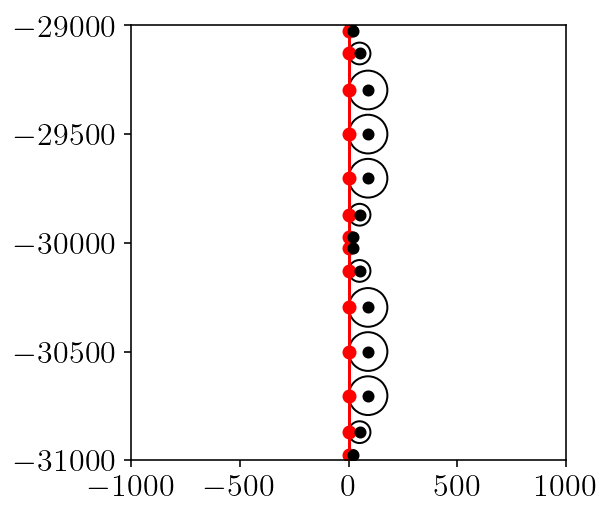

In [49]:
plot_centers(report, [-1000,1000], [-31000,-29000])
plt.show()

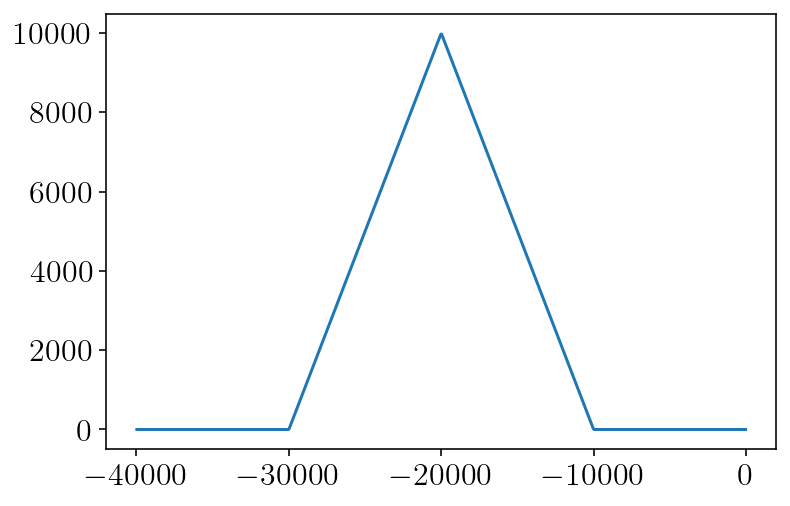

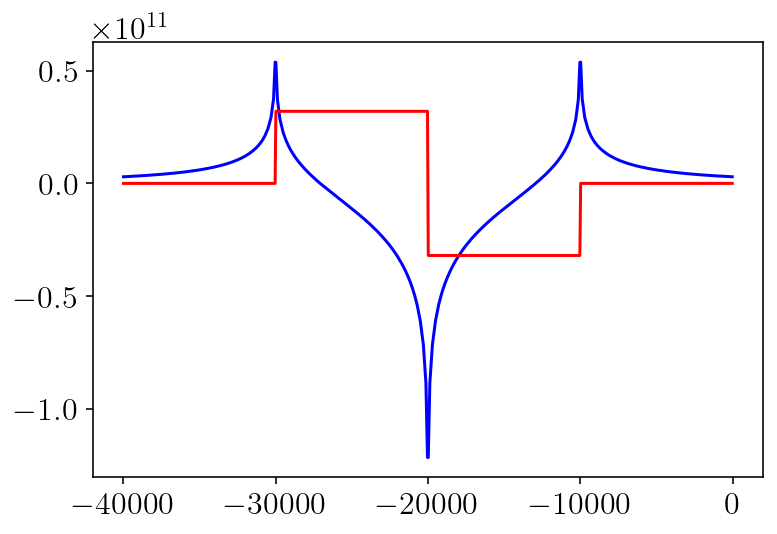

In [50]:
fy = fault.pts[:,1]
v = -np.abs(fy + 20000) + 10000
slip = np.where(v > 0, v, 0)
plt.plot(fy, slip)
plt.show()
stress = tensor_dot(fault_slip_to_fault_stress, slip)
true_syz = np.where(fy > -30000, np.where(fy < -20000, shear_modulus, np.where(fy < -10000, -shear_modulus, 0)), 0)
plt.plot(fy,stress[:,0],'b-')
plt.plot(fy,stress[:,1],'r-')
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_81072/2249571773.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fy, np.log10(np.abs((stress[:,1] - true_syz) / shear_modulus)))


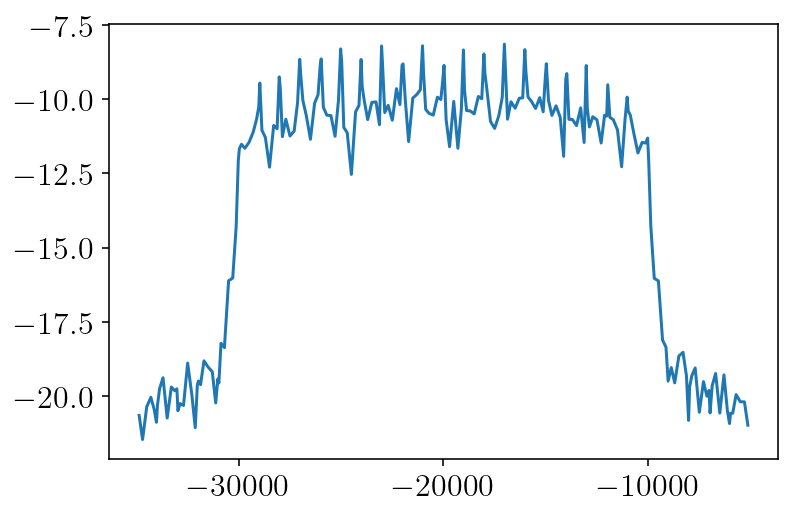

In [51]:
plt.plot(fy, np.log10(np.abs((stress[:,1] - true_syz) / shear_modulus)))
plt.show()

In [69]:
import quadpy
S = quadpy.c1.gauss_kronrod(7)
S2 = quadpy.c1.gauss_legendre(7)
S.points, S.weights, S2.weights

(array([-9.91455371e-01, -9.49107912e-01, -8.64864423e-01, -7.41531186e-01,
        -5.86087235e-01, -4.05845151e-01, -2.07784955e-01,  7.77156117e-16,
         2.07784955e-01,  4.05845151e-01,  5.86087235e-01,  7.41531186e-01,
         8.64864423e-01,  9.49107912e-01,  9.91455371e-01]),
 array([0.02293532, 0.06309209, 0.10479001, 0.14065326, 0.16900473,
        0.19035058, 0.20443294, 0.20948214, 0.20443294, 0.19035058,
        0.16900473, 0.14065326, 0.10479001, 0.06309209, 0.02293532]),
 array([0.12948497, 0.27970539, 0.38183005, 0.41795918, 0.38183005,
        0.27970539, 0.12948497]))

In [72]:
(S.weights * (S.points ** 22)).sum() - (2.0 / 23)

-8.187894806610529e-16

In [35]:
stress[:,1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.38353287e-11, -2.06747190e-10, -2.09139481e-10,  3.62407753e-10,
       -8.52458493e-11, -8.52861605e-11, -3.84893372e-11,  1.04160370e-10,
        1.67791118e-09, -8.65719761e-11,  1.86256577e-09,  7.28644681e-10,
       -8.74355912e-11, -4.98824442e-10, -3.20473824e-10,  9.91157602e-10,
        9.25751651e-11, -

In [16]:
shear_modulus/1e10

3.2

In [7]:
from tectosaur2.mesh import build_interp_matrix, build_interpolator
Im = build_interp_matrix(build_interpolator(fault.qx), np.array([-1,1]))
Im = np.array(Im)

In [8]:
field = stress[:,0]
nq = fault.panel_order
edge_vals = np.empty((fault.n_panels, 2))
for i in range(fault.n_panels):
    panel_vals = field[i*nq:(i+1)*nq]
    edge_vals[i] = [Im[0].dot(panel_vals), Im[1].dot(panel_vals)]

In [9]:
edge_vals[:5]

array([[1.46518590e+09, 1.65723950e+09],
       [1.65723965e+09, 1.89282241e+09],
       [1.89282270e+09, 2.18744500e+09],
       [2.18744560e+09, 2.56497399e+09],
       [2.56497537e+09, 3.06436533e+09]])

In [10]:
edge_vals[1:,0] - edge_vals[:-1,1]

array([ 1.56404250e+02,  2.93517722e+02,  6.00656394e+02,  1.38166086e+03,
        3.75692667e+03,  1.32365080e+04,  7.38772989e+04,  1.94032718e+07,
       -1.97032011e+09,  7.90184211e+09, -8.65864692e+07, -2.37489142e+05,
       -3.03086852e+04, -1.02849887e+04, -1.21939377e+04, -3.89237553e+04,
       -2.48251523e+05,  1.25187284e+08, -1.11130044e+10,  1.11130044e+10,
       -1.25187271e+08,  2.48267786e+05,  3.89320191e+04,  1.22063541e+04,
        1.02926278e+04,  3.03181236e+04,  2.37491860e+05,  8.65864725e+07,
       -7.90184211e+09,  1.97032011e+09, -1.94032718e+07, -7.38772989e+04,
       -1.32365080e+04, -3.75692667e+03, -1.38166085e+03, -6.00656386e+02,
       -2.93517723e+02, -1.56404249e+02])

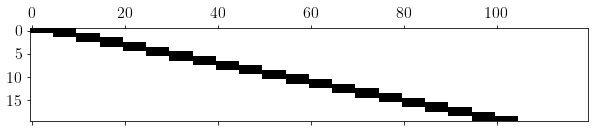

In [11]:
constraints = np.zeros((fault.n_panels - 1, fault.n_pts))
for i in range(fault.n_panels-1):
    constraints[i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
    constraints[i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
fault_slip_to_fault_stress
plt.figure(figsize=(10,10))
plt.spy(constraints[:20,:120])
plt.show()

In [28]:
constraints.shape

(38, 195)

In [29]:
stress.shape

(195, 2)